In [1]:
from __future__ import print_function, division
#virtualenv -p python3 venv

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cPickle as pk
import pandas as pd
import numpy as np
from IPython.display import clear_output

In [3]:
import os
import sys
base_module_path = os.path.abspath(os.path.join('..'))
if base_module_path not in sys.path:
    sys.path.append(base_module_path)
import cervix as c

Using TensorFlow backend.


In [4]:
ls ../data/train/

Type_1/  Type_2/  Type_3/


In [5]:
df = c.data.make_base_df()
df = c.processing.transform_save_imgs(df, c.processing.resize_n, n=224);

In [6]:
train, validate = c.data.split_df(df); 

In [7]:
print(train.shape)
train.head()

(1332, 5)


,path,Type,filetype,num_id,processed_path
137,../data/train/Type_1/102.jpg,1,jpg,102,../data/processed/resize_224/train/102.jpg
130,../data/train/Type_1/1105.jpg,1,jpg,1105,../data/processed/resize_224/train/1105.jpg
1032,../data/train/Type_3/573.jpg,3,jpg,573,../data/processed/resize_224/train/573.jpg
177,../data/train/Type_1/1389.jpg,1,jpg,1389,../data/processed/resize_224/train/1389.jpg
1303,../data/train/Type_3/1048.jpg,3,jpg,1048,../data/processed/resize_224/train/1048.jpg


In [8]:
print(validate.shape)
validate.head()

(149, 5)


,path,Type,filetype,num_id,processed_path
1453,../data/train/Type_3/670.jpg,3,jpg,670,../data/processed/resize_224/train/670.jpg
1202,../data/train/Type_3/427.jpg,3,jpg,427,../data/processed/resize_224/train/427.jpg
1403,../data/train/Type_3/635.jpg,3,jpg,635,../data/processed/resize_224/train/635.jpg
162,../data/train/Type_1/230.jpg,1,jpg,230,../data/processed/resize_224/train/230.jpg
625,../data/train/Type_2/1329.jpg,2,jpg,1329,../data/processed/resize_224/train/1329.jpg


# Model creation

In [45]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
#keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# remove most of VGG16 to leave only the first two conv blocks (basic features)
#ie remove top 12 layers
for _ in range(12):
    base_model.layers.pop()
base_model = Model(base_model.input, base_model.layers[-1].output)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(64, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
    # we have three classes so usung 3 on dense predictions
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [46]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 global_average_pooling2d_3 True
8 dense_5 True
9 dense_6 True


In [47]:
for layer in model.layers[:1]:
    layer.trainable = False
for layer in model.layers[1:]:
    layer.trainable = True

In [64]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 global_average_pooling2d_3 True
8 dense_5 True
9 dense_6 True


In [65]:
# compile the model (should be done *after* setting layers to non-trainable)
# TODO: loss function should be log loss. 'categorical_crossentropy' / c.submission.keras_log_loss
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [66]:
features, labels = c.processing.df_to_training_tuples(train, (224, 224, 3), grayscale=False)
val_data = c.processing.df_to_training_tuples(validate, (224,224, 3), grayscale=False)

In [67]:
history = c.analysis.History()

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [69]:
# train the model on the new data for a few epochs
import keras
print('backend : '+keras.backend.backend())
model_history = model.fit(features, labels, batch_size=32, epochs=100, validation_data=val_data,
                          callbacks=[history, keras.callbacks.EarlyStopping(patience=50)])


backend : tensorflow
Train on 1332 samples, validate on 149 samples
Epoch 1/100
1120/1332 [========================>.....] - ETA: 5s - loss: 13.3406

KeyboardInterrupt: 

In [73]:
for layer in model.layers[-1:]:
    print(layer)
    print(layer.get_weights()[1])

[[ 0.17102844 -0.17987984  0.13154227]
 [-0.02458662 -0.04170778 -0.26176536]
 [-0.27353334 -0.10423766 -0.23635256]
 [-0.24133311 -0.08028476  0.16892368]
 [ 0.28963858 -0.16379465 -0.05997714]
 [ 0.28932774 -0.1280757   0.10322946]
 [-0.26624051 -0.17591065 -0.08313753]
 [-0.0549687   0.19910961 -0.22700483]
 [-0.2323643  -0.0815414   0.0331834 ]
 [ 0.2682178   0.23799318 -0.08071114]
 [-0.20131299 -0.2087436  -0.10435753]
 [-0.22338195 -0.21253115 -0.25659776]
 [ 0.24173927 -0.1272781  -0.04736435]
 [-0.02585566  0.26969922  0.11686829]
 [ 0.0584043   0.17673007 -0.04764253]
 [ 0.12145993  0.16507134 -0.23387837]
 [ 0.10942635  0.17896476 -0.17049639]
 [ 0.25959349 -0.25784039  0.0686281 ]
 [ 0.24485552  0.22230262  0.11820057]
 [ 0.20533484  0.17725599  0.07443541]
 [-0.26315799 -0.29383498  0.06498745]
 [ 0.14496294 -0.00736412 -0.28082091]
 [ 0.22638845  0.06248644  0.04673728]
 [-0.16768807  0.25725609  0.020852  ]
 [-0.20021486 -0.15861675  0.07729372]
 [ 0.12282139 -0.19031399

In [58]:
labels.sum(0)

array([ 227.,  707.,  398.])

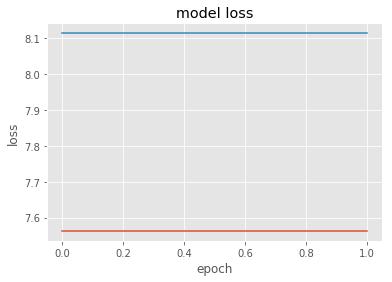

In [52]:
c.analysis.plot_log_errors(history)

In [59]:
predictions = model.predict(val_data[0])
predictions

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.

In [60]:
predictions.sum(0)

array([ 149.,    0.,    0.], dtype=float32)

In [ ]:
test_p = c.processing.append_probabilities(test, predictions, ['1','2','3']); test_p.head()

In [ ]:
test_p.Type.value_counts()

In [ ]:
predictions.sum(0)

In [ ]:
score, ldf = c.submission.compute_losses(test_p)

In [ ]:
score

In [ ]:
ldf.sort_values('Type_1', ascending=False)

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[0])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[0])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[1])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[1])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[3])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[3])